In [1]:
print("hi")

hi


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision
print("torch:", torch.__version__)
print("CUDA toolkit:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())
print("torchvision:", torchvision.__version__)
print(torch.backends.cudnn.version())

torch: 0.3.1
CUDA toolkit: 9.0.176
GPU available: True
torchvision: 0.2.1
7005


In [3]:
from fastai.conv_learner import*
from fastai.dataset import*

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

torch.cuda.set_device(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla T4


In [6]:
PATH = Path('../data/pascal_2007')
list(PATH.iterdir())

[PosixPath('../data/pascal_2007/models'),
 PosixPath('../data/pascal_2007/segmentation'),
 PosixPath('../data/pascal_2007/test'),
 PosixPath('../data/pascal_2007/test.csv'),
 PosixPath('../data/pascal_2007/test.json'),
 PosixPath('../data/pascal_2007/tmp'),
 PosixPath('../data/pascal_2007/train'),
 PosixPath('../data/pascal_2007/train.csv'),
 PosixPath('../data/pascal_2007/train.json'),
 PosixPath('../data/pascal_2007/valid.json')]

In [7]:
trn_j = json.load((PATH/'train.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [8]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [9]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [10]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

In [11]:
FILENAME, ID, IMG_ID, CAT_ID,BBOX = 'file_name', 'id', 'image_id','category_id', 'bbox'

In [12]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILENAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]] 

In [13]:
JPEGS= PATH/'train'

In [14]:
IMG_PATH = Path('../data/pascal_2007/train')
#IMG_PATH = Path(JPEGS)
list(IMG_PATH.iterdir())[:5]

[PosixPath('../data/pascal_2007/train/000005.jpg'),
 PosixPath('../data/pascal_2007/train/000007.jpg'),
 PosixPath('../data/pascal_2007/train/000009.jpg'),
 PosixPath('../data/pascal_2007/train/000012.jpg'),
 PosixPath('../data/pascal_2007/train/000016.jpg')]

In [15]:
im0_d = trn_j[IMAGES][0]
im0_d[FILENAME], im0_d[ID]

('000012.jpg', 12)

In [16]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
        
len(trn_anno)

2501

In [17]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [18]:
im0_a = im_a[0];im0_a

(array([ 96, 155, 269, 350]), 7)

In [19]:
cats[7]

'car'

In [20]:
trn_anno[17]
list(trn_anno)[:5]

[12, 17, 23, 26, 32]

In [21]:
cats[15],cats[13]

('person', 'horse')

In [22]:

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [23]:
im = open_image(IMG_PATH/im0_d[FILENAME])

In [24]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [25]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [26]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [27]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

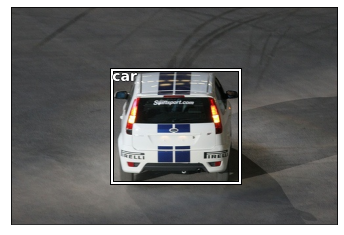

In [28]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [29]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [30]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(281, 500, 3)


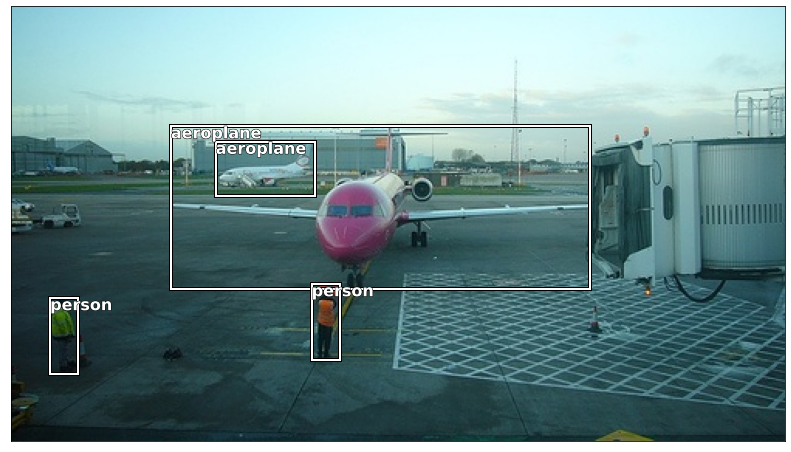

In [31]:
draw_idx(32)

### Step 1. Largest item classifier

In [32]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [33]:
trn_lrg_anno = {a: get_lrg(b) for a, b in trn_anno.items()}

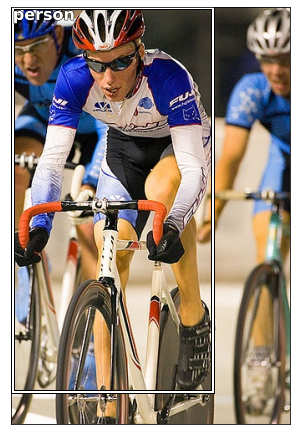

In [34]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [35]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV= PATH/'tmp/lrg.csv'

In [36]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                  'cat' : [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [37]:
f_model = resnet34
sz=224
bs=64

In [38]:
trn_IMG_PATH = 'train'

In [39]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, CSV, tfms=tfms)

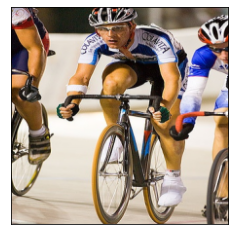

In [40]:
x, y = next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [41]:
learn = ConvLearner.pretrained(f_model, md, metrics = [accuracy])
learn.opt_fn = optim.Adam

In [42]:
#torch.cuda.empty_cache()
#os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:2'

In [43]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [44]:
lrf = learn.lr_find(1e-5, 100)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

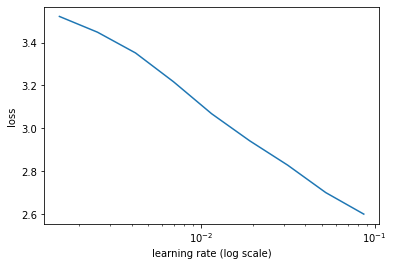

In [45]:
learn.sched.plot()

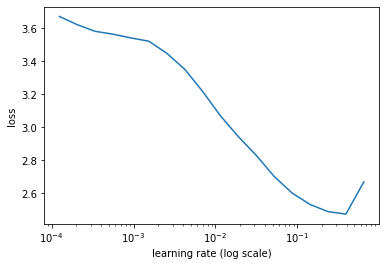

In [46]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [47]:
lr = 2e-2

In [48]:
learn.fit(lr, 1, cycle_len=1)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                 
    0      1.301441   0.657774   0.802     


[array([0.65777]), 0.8019999976158142]

In [49]:
lrs = np.array([lr/100,lr/100,lr])

In [50]:
learn.freeze_to(-2)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

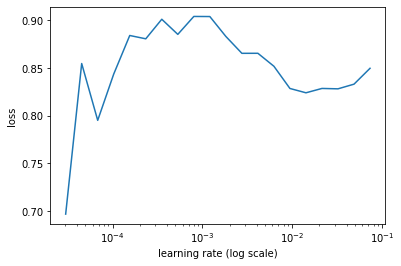

In [51]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [52]:
learn.fit(lrs/5,1,cycle_len=1)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                  
    0      0.790684   0.590486   0.822     


[array([0.59049]), 0.8220000023841858]

In [53]:
learn.unfreeze()

In [54]:
learn.fit(lrs/5, 1,cycle_len=2)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                  
    0      0.628782   0.560578   0.838     
    1      0.446378   0.557857   0.838                     


[array([0.55786]), 0.8379999980926514]

In [55]:
learn.save('class_one')

In [59]:
print(learn.data.path)

../data/pascal_2007


In [56]:
learn.load('class_one')

In [57]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


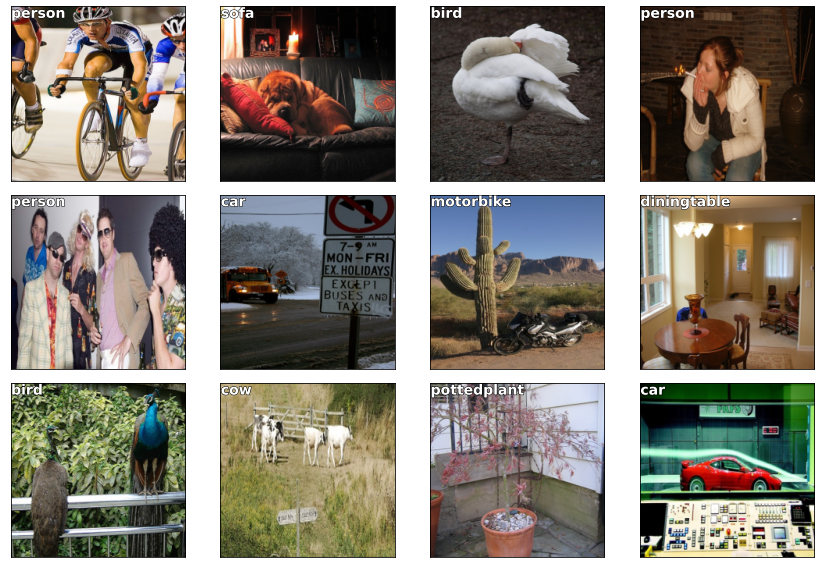

In [58]:
fig, axes = plt.subplots(3,4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()